# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [6]:
# Set directories
fastq.dir = "/nfs/lab/projects/COVID_mouse/raw_data/230616_A01535_0344_BH7LF2DSX7_2/"
base.dir = "/nfs/lab/projects/COVID_mouse/"
assets.dir = "/nfs/lab/projects/COVID_mouse/assets/"
cell.ranger.dir = paste(base.dir, "cell.ranger/", sep = "")
seurat.dir = paste(base.dir, "seurat/", sep = "")
step1.dir = paste(seurat.dir, "1_pre.processing/", sep = "")
step2.dir = paste(seurat.dir, "2_SoupX/", sep = "")
step3.dir = paste(seurat.dir, "3_scrublet/", sep = "")

In [7]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".3.3_doublet.cleanup.log", sep="")

In [8]:
log_open(log.file)

[1] "/nfs/lab/projects/COVID_mouse/log/2023-08-21.3.3_doublet.cleanup.log"

# Load sample list

In [10]:
setwd(cell.ranger.dir)
sample.ls = dir()
sample.ls
sample.ID.ls = sample.ls

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
 [8] "5_RBD2"  "6_RBD3"  "7_G1B1"  "8_G1B2"  "9_G1B3"

# Filter Scrublet barcodes

In [11]:
qc.data = NULL

for (i in seq_along(sample.ls)){
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    sample.ID = sample.ID.ls[i]
    log_print(paste("Processing: ", sample.ID))
    # Load sample
    adata = readRDS(file = paste(step2.dir, sample.ID, "_SoupX_filt.rds", sep = ""))
    # Grab Idents
    cells = Cells(adata)

    ## SCRUBLET
    log_print(" - Working with Scrublet results")
    # Load Scrublet results
    scrublet.thresh = read.table(paste(step3.dir, sample.ID, "_auto_threshold.txt", sep = ""), sep = "\t", header = FALSE)
    scrublet.metadata = read.table(paste(step3.dir, sample.ID, "_scrublet_predicted_doublets.txt", sep = ""), sep = "\t", header = FALSE)
    scrublet.mult <- as.vector(scrublet.metadata$V1[scrublet.metadata$V2 == 'True'])

    # Mark doublets
    scrublet.mult.metadata <- rep("singlet", length(cells))
    names(scrublet.mult.metadata) <- cells
    scrublet.mult.metadata[scrublet.mult] <- "multiplet"

    # add metadata column
    adata <- AddMetaData(adata, scrublet.mult.metadata, col.name = "multiplet.scrublet")
    
    # Scrublet contamination plots for visualization of the original RDS 
    file = paste(step3.dir, sample.ID,"_Scrublet_UMAPs.png", sep = "")
    png(file, width = 576, height = 576)
    p1 <- DimPlot(adata, group.by='multiplet.scrublet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"),
                  order = c("multiplet.scrublet", "singlet"))
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(sample.ID) + theme(legend.position = "none")
    print(p1)
    garbage <- dev.off()
    
    # Filter RDS
    adata = AddMetaData(adata, scrublet.mult.metadata, col.name = "multiplet.scrublet")   
    adata.scrublet = subset(x = adata, subset = multiplet.scrublet == "singlet")
        
        # Grab stats for RNA
        RNA.feature.mean = mean(adata.scrublet$nFeature_RNA)
        RNA.feature.median = median(adata.scrublet$nFeature_RNA)
        percent.mt.median = median(adata.scrublet$percent.mt)
        percent.mt.mean = mean(adata.scrublet$percent.mt)
        # Pileup QC
        qc.data$sample.ID = rbind(qc.data$sample.ID, sample.ID)
        qc.data$barcodes = rbind(qc.data$barcodes, length(cells))
        qc.data$scrublet.mult = rbind(qc.data$scrublet.mult, length(scrublet.mult))
        qc.data$scrublet.thresh = rbind(qc.data$scrublet.thresh, scrublet.thresh)
        qc.data$RNA.feature.mean = rbind(qc.data$RNA.feature.mean, RNA.feature.mean)
        qc.data$RNA.feature.median = rbind(qc.data$RNA.feature.median, RNA.feature.median)
        qc.data$percent.mt.mean = rbind(qc.data$percent.mt.mean, percent.mt.mean)
        qc.data$percent.mt.median = rbind(qc.data$percent.mt.median, percent.mt.median)
        log_print(" - Done!!")

    ### Save  RDS
    file = paste(step3.dir, sample.ID, "_filt.rm_mult.rds", sep = "")
    saveRDS(adata.scrublet, file = file)

    ## Save barcodes
    file = paste(step3.dir, sample.ID, "_filt.rm_mult.txt", sep = "")
    filtered_bcs <- colnames(adata.scrublet[["RNA"]])
    write(filtered_bcs, file=file) 
    
    
}
file = paste(step3.dir, "Cell.res.qc", sep = "")
qc.data = as.data.frame(qc.data)
write.table(qc.data, file, sep='\t', row.names=FALSE, col.names=TRUE, quote=FALSE)

[1] "Processing:  1_GFP1"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  10_G1C1"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  11_G1C2"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  12_G1C3"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  2_GFP2"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  3_GFP3"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  4_RBD1"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  5_RBD2"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  6_RBD3"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  7_G1B1"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  8_G1B2"
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  9_G1B3"
[1] " - Working with Scrublet results"
[1] " - Done!!"


In [12]:
qc.data = read.table(paste(step3.dir, "Cell.res.qc", sep = ""), sep = "\t", header = TRUE)
colnames(qc.data)[4] = "scrublet.thresh"
qc.data$multiplets.pct = (qc.data$scrublet.mult/qc.data$barcodes)*100

In [13]:
head(qc.data, n = 2)

,sample.ID,barcodes,scrublet.mult,scrublet.thresh,RNA.feature.mean,RNA.feature.median,percent.mt.mean,percent.mt.median,multiplets.pct
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,1_GFP1,12024,414,0.2556373,1936.320,1620.5,0,0,3.443114
2,10_G1C1,14679,292,0.2837941,2717.923,2317.0,0,0,1.989236


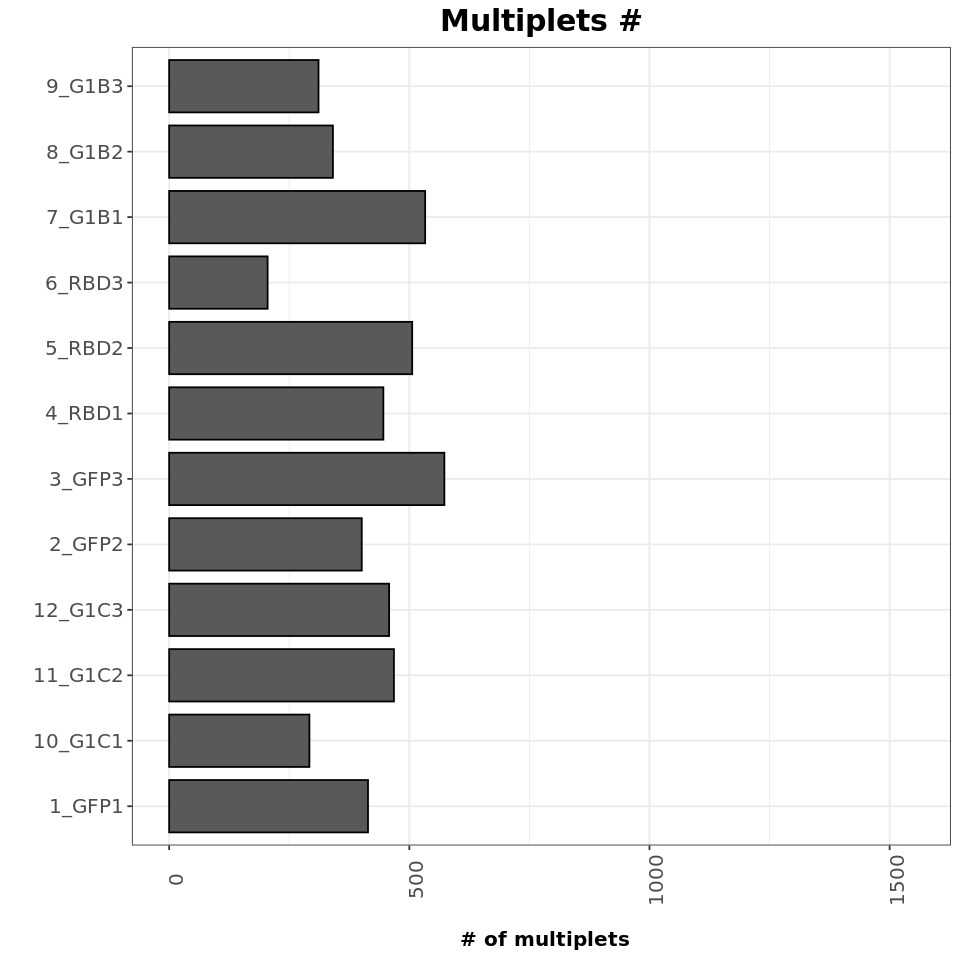

In [14]:
options(repr.plot.width=8, repr.plot.height=8)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = scrublet.mult)) + 
            theme_bw () +
            labs(y= "\n # of multiplets", x = "", title = "Multiplets #") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0,1550)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg1

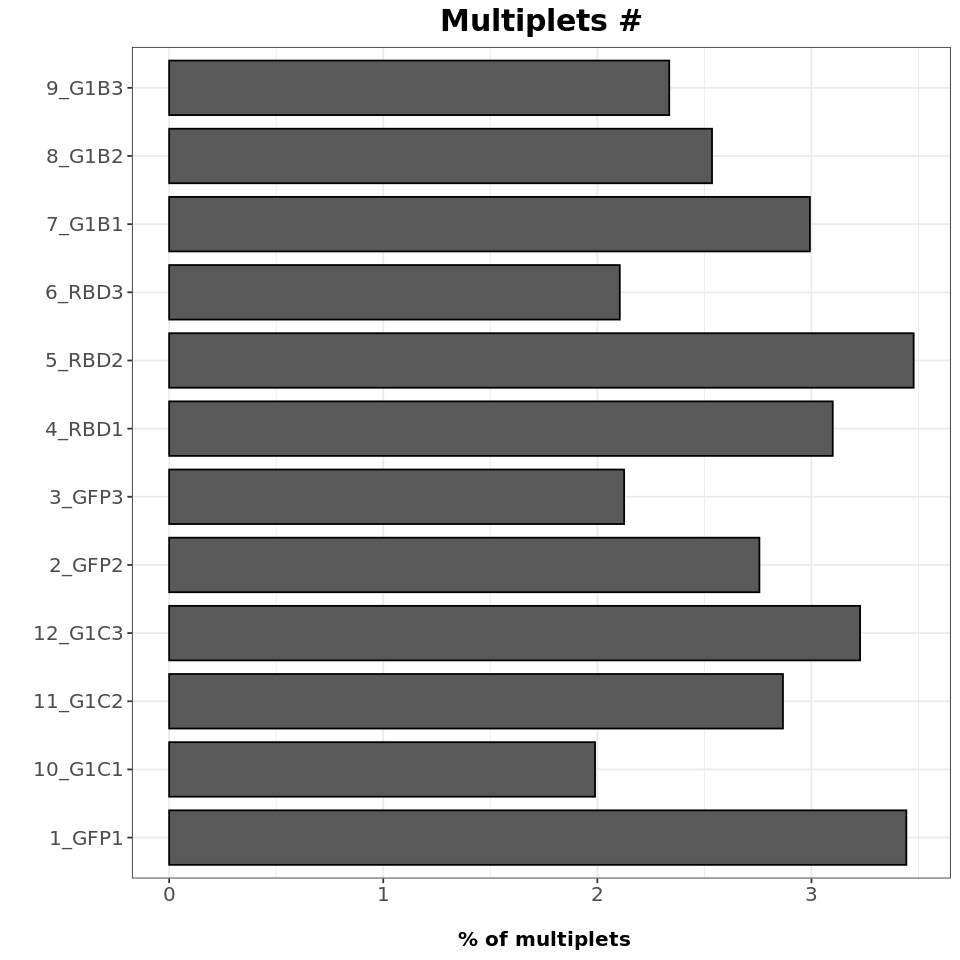

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = multiplets.pct)) + 
            theme_bw () +
            labs(y= "\n % of multiplets", x = "", title = "Multiplets #") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                                               plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg1

In [16]:
qc.data

sample.ID,barcodes,scrublet.mult,scrublet.thresh,RNA.feature.mean,RNA.feature.median,percent.mt.mean,percent.mt.median,multiplets.pct
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1_GFP1,12024,414,0.2556373,1936.320,1620.5,0,0,3.443114
10_G1C1,14679,292,0.2837941,2717.923,2317.0,0,0,1.989236
11_G1C2,16325,468,0.2713505,2607.452,2463.0,0,0,2.866769
12_G1C3,14192,458,0.2395585,2452.818,2129.0,0,0,3.227170
2_GFP2,14546,401,0.2726426,1985.163,1668.0,0,0,2.756772
3_GFP3,26964,573,0.2500000,1464.443,1170.0,0,0,2.125056
4_RBD1,14390,446,0.2726426,2059.611,1723.0,0,0,3.099375
5_RBD2,14552,506,0.2394168,2358.346,2030.0,0,0,3.477185
6_RBD3,9740,205,0.2500000,2050.358,1651.0,0,0,2.104723


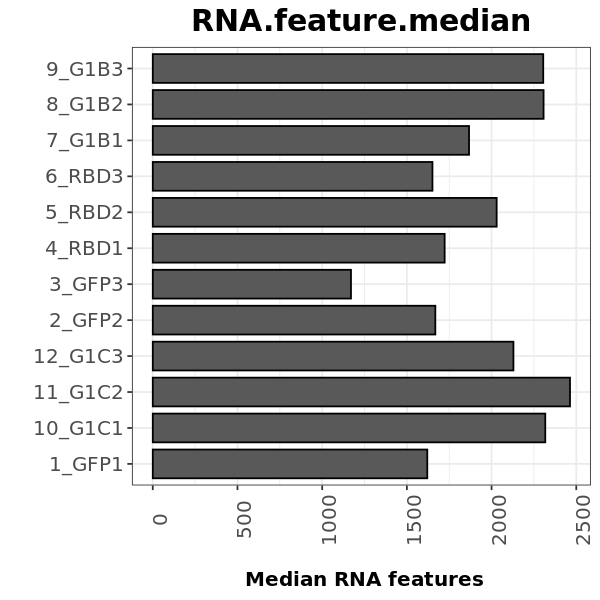

In [17]:
# Plot median features
options(repr.plot.width=5, repr.plot.height=5)
width = 0.8
ggplot(qc.data, aes(x= sample.ID, y = RNA.feature.median)) + 
            theme_bw () +
            labs(y= "\n Median RNA features", x = "", title = "RNA.feature.median") +
            geom_bar(stat="identity", 
                     position = position_dodge(width = width), width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

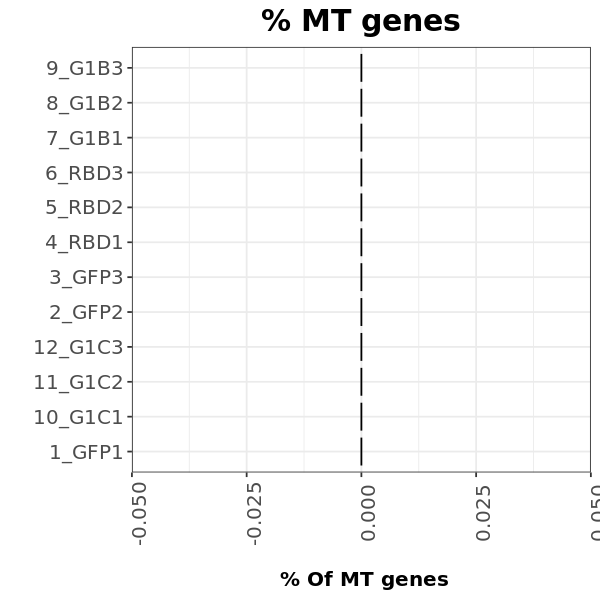

In [18]:
options(repr.plot.width=5, repr.plot.height=5)

width = 0.8
position = position_dodge(width = width)
ggplot(qc.data, aes(x= sample.ID, y = percent.mt.median)) + 
            theme_bw () +
            labs(y= "\n % Of MT genes", x = "", title = "% MT genes") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()


In [19]:
qc.data$final.barcodes = qc.data$barcodes - qc.data$scrublet.mult

In [20]:
qc.data

sample.ID,barcodes,scrublet.mult,scrublet.thresh,RNA.feature.mean,RNA.feature.median,percent.mt.mean,percent.mt.median,multiplets.pct,final.barcodes
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
1_GFP1,12024,414,0.2556373,1936.320,1620.5,0,0,3.443114,11610
10_G1C1,14679,292,0.2837941,2717.923,2317.0,0,0,1.989236,14387
11_G1C2,16325,468,0.2713505,2607.452,2463.0,0,0,2.866769,15857
12_G1C3,14192,458,0.2395585,2452.818,2129.0,0,0,3.227170,13734
2_GFP2,14546,401,0.2726426,1985.163,1668.0,0,0,2.756772,14145
3_GFP3,26964,573,0.2500000,1464.443,1170.0,0,0,2.125056,26391
4_RBD1,14390,446,0.2726426,2059.611,1723.0,0,0,3.099375,13944
5_RBD2,14552,506,0.2394168,2358.346,2030.0,0,0,3.477185,14046
6_RBD3,9740,205,0.2500000,2050.358,1651.0,0,0,2.104723,9535


In [21]:
qc.data = qc.data %>% gather(barcodes.type, barcodes, c(2,10))
qc.data$barcodes.type = factor(qc.data$barcodes.type, 
                                levels = rev(c("barcodes", "final.barcodes")))


gather: reorganized (final.barcodes) into (barcodes.type) [was 12x10, now 24x10]


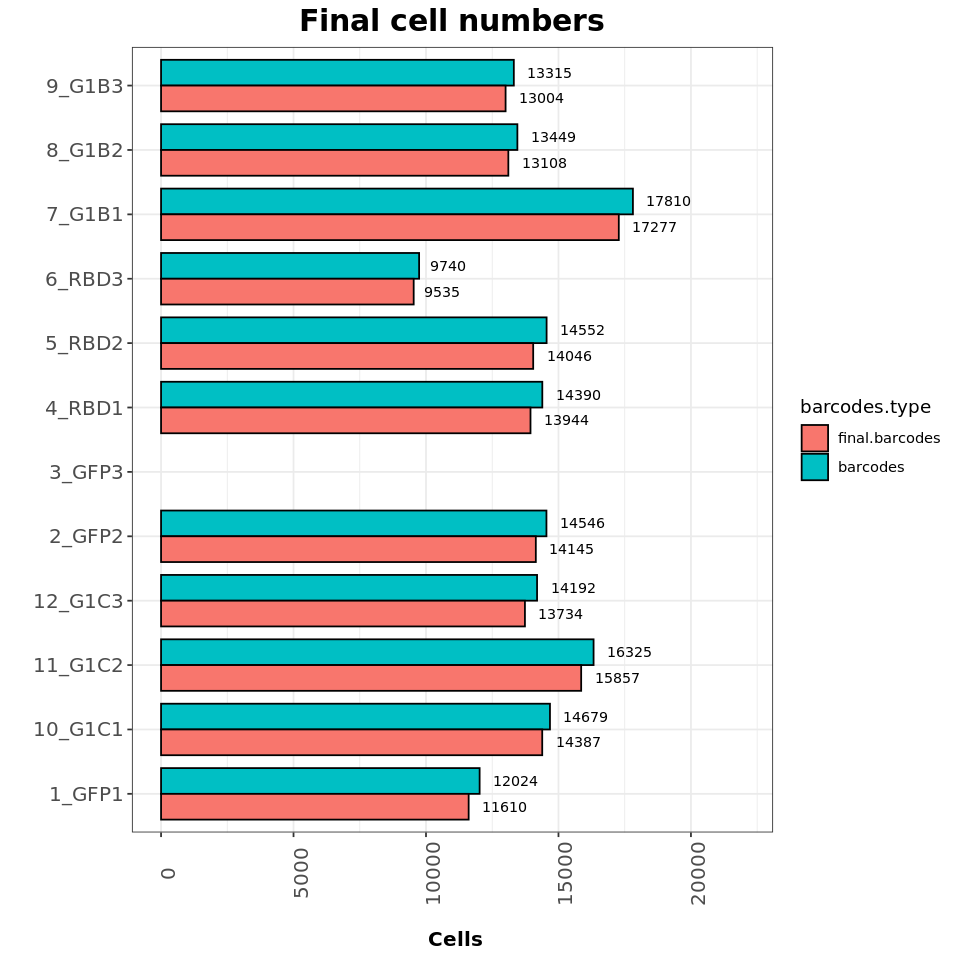

In [22]:
options(repr.plot.width=8, repr.plot.height=8)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = barcodes, fill = barcodes.type, label = barcodes)) + 
            theme_bw () +
            labs(y= "\n Cells", x = "", title = "Final cell numbers") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            ylim(0, 22000)+
            coord_flip()+
            geom_text(hjust = -0.3, size = 3, position = position_dodge(width = width))
gg1

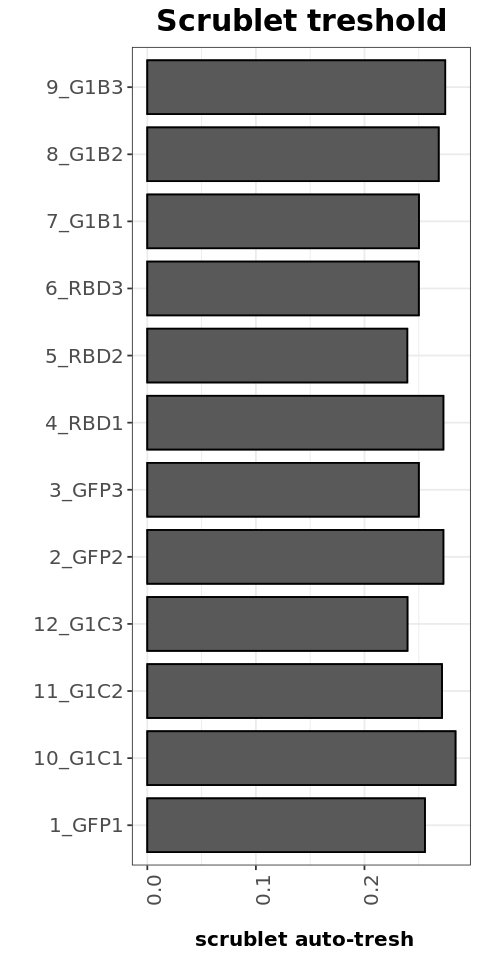

In [23]:
options(repr.plot.width=4, repr.plot.height=8)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = scrublet.thresh)) + 
            theme_bw () +
            labs(y= "\n scrublet auto-tresh", x = "", title = "Scrublet treshold") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg1

# Analyse filtered object and overwrite

In [24]:
for (i in seq_along(sample.ls)){
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    sample.ID = sample.ID.ls[i]
    log_print(paste("Analysing :", sample.ID))
    adata = readRDS(paste(step3.dir, sample.ID, "_filt.rm_mult.rds", sep = ""))
    
    # RNA analysis
    DefaultAssay(adata) <- 'RNA'
    adata <- SCTransform(adata, verbose = FALSE) 
    
    DefaultAssay(adata) <- "SCT"
    adata = RunPCA(adata, verbose = FALSE)
    adata = RunUMAP(adata, dims = 1:30, verbose = FALSE)
    adata = FindNeighbors(adata, dims = 1:30, verbose = FALSE)
    adata = FindClusters(adata, algorithm = 4, resolution = 0.5, verbose = FALSE)

    
    # Generate UMAPS
    file = paste(step3.dir, sample.ID,"_UMAPs.png", sep = "")
    png(file, width = 576, height = 576)
    p1 <- DimPlot(adata, group.by='seurat_clusters', label=TRUE, label.size=8, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(sample.ID) + theme(legend.position = "none")
    print(p1)
    garbage <- dev.off()
    
    # Make Violin plots
    file = paste(step3.dir, sample.ID,"_metrics.png", sep = "")
    png(file, width = 2304, height = 1536)
    p1 <- VlnPlot(adata, features='nCount_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p2 <- VlnPlot(adata, features='nFeature_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p3 <- VlnPlot(adata, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p4 <- VlnPlot(adata, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    figure <- ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2,
                        common.legend = TRUE,legend="none")
    print(figure)
    garbage <- dev.off()
    
    # Plot RNA features post filters
    file = paste(step3.dir, sample.ID,"_RNA.features.density.png", sep = "")
    png(file, width = 576, height = 576)
    options(repr.plot.width=8, repr.plot.height=8)
    data = as.numeric(adata@meta.data$nFeature_RNA)
    data[data > 10000] = 10000
    quants = quantile(data)
    figure = ggplot(data=adata@meta.data, mapping = aes(x=data)) +
                labs(title = paste(sample.ID, "\n", "RNA Features \n\n", 
                              paste("q2:", quants[2], '|',
                                    "q3:", quants[3], '|',
                                    "q4:", quants[4], '|'),sep = "")) +
                geom_density(alpha = 0.2, fill= 'lightpink', color="pink") + 
                theme_linedraw() + labs(x="nFeature_RNA") +
                geom_vline(xintercept=c(quants[2],quants[3],quants[4]), 
                           colour=c("blue", "red", "black"),linetype = "longdash") +
                scale_x_continuous(breaks=c(0,2000, 4000, 6000, 8000 ,10000),
                                   labels=c("0", "2k", "4k", "6k", "8k", ">=10k"))+
                theme(title=element_blank(),
                axis.text.x=element_text(size=20, vjust=0.5, angle = 90),
                axis.text.y=element_text(size=20, vjust=0.5),
                axis.title.x = element_text(size=25, vjust=-0.35),
                axis.title.y = element_text(size=25, vjust=0.5),
                plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))
    print(figure)
    garbage <- dev.off()
    
    
    ### Overwrite  RDS
    file = paste(step3.dir, sample.ID, "_filt.rm_mult.rds", sep = "")
    saveRDS(adata, file = file)
}

[1] "Analysing : 1_GFP1"
[1] "Analysing : 10_G1C1"
[1] "Analysing : 11_G1C2"
[1] "Analysing : 12_G1C3"
[1] "Analysing : 2_GFP2"
[1] "Analysing : 3_GFP3"
[1] "Analysing : 4_RBD1"
[1] "Analysing : 5_RBD2"
[1] "Analysing : 6_RBD3"
[1] "Analysing : 7_G1B1"
[1] "Analysing : 8_G1B2"
[1] "Analysing : 9_G1B3"
